# Imports and Data Preparation

Comparisions for RF-GAP
    - MALI
    - KEMA (MAT-LAB); wait


Some Ideas:
- Since this method requires labels, we could classiy different domains based on the labels. For example, if we have a data set of people sick with Creutzfeld-Jakob discease and the other domain is people who are sick with alzheimers. 

In [94]:
from mashspud import MASH
import numpy as np
import pandas as pd
import Main.test_manifold_algorithms as tma
from mashspud import SPUD
from Helpers.rfgap import RFGAP
import matplotlib.pyplot as plt
from Helpers.Pipeline_Helpers import rf_test_proximities

#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="seeds.csv", split = "skewed", percent_of_anchors= [0.2], verbose = 4, random_state= 42)

MDS initialized with 3 components

 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [70]:
np.unique(dc.split_A[:,-1])

array([0.        , 0.04234367, 0.04332841, 0.06400788, 0.09059577,
       0.10782866, 0.12900049, 0.12949286, 0.12998523, 0.13540128,
       0.14081733, 0.1506647 , 0.1521418 , 0.15312654, 0.1723289 ,
       0.17282127, 0.17380601, 0.19448548, 0.21516494, 0.21565731,
       0.21614968, 0.21762678, 0.21861152, 0.23732152, 0.23781388,
       0.23830625, 0.24273757, 0.25553914, 0.25849335, 0.25898572,
       0.25947809, 0.26095519, 0.26440177, 0.26784835, 0.26981782,
       0.28015756, 0.28064993, 0.28163466, 0.28212703, 0.28458887,
       0.29148203, 0.30182176, 0.30329887, 0.30379124, 0.30773018,
       0.30920729, 0.31068439, 0.31462334, 0.3229936 , 0.32348597,
       0.3244707 , 0.32545544, 0.32644018, 0.32791728, 0.3323486 ,
       0.3446578 , 0.34515017, 0.34564254, 0.34613491, 0.34711965,
       0.34908912, 0.35056622, 0.36632201, 0.36976859, 0.37223043,
       0.38404727, 0.38798621, 0.38847858, 0.38897095, 0.38946332,
       0.39143279, 0.39241753, 0.40324963, 0.40965042, 0.41014

In [71]:
def use_rf_proximities(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

        #Change known_anchors to correspond to off diagonal matricies -- We have to change this as its dependent upon A
        self.known_anchors_adjusted = np.vstack([self.known_anchors.T[0], self.known_anchors.T[1] + self.len_A]).T

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 0

    return 1 - dataA

# Applying RF GAP for SPUD

In [72]:
#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = use_rf_proximities, distance_measure_B= use_rf_proximities, knn = 3, verbose = 4)

#Fit SPUD
spud_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:3])

Time it took to compute SGDM:  0.52
Time it took to execute graphtools.Graph functions:  0.14
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.01
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


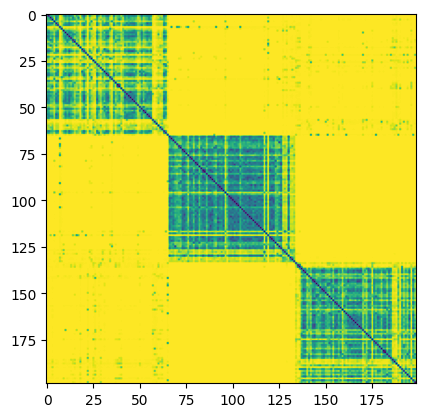

In [73]:
plt.imshow(spud_class.block[:spud_class.len_A, :spud_class.len_A])


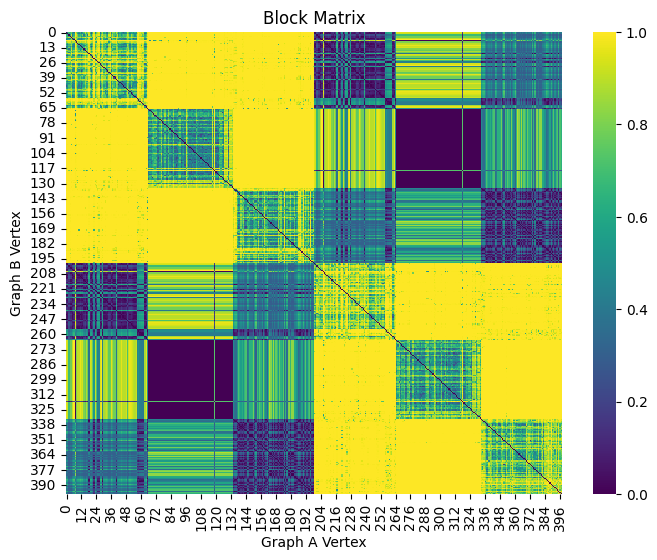

In [74]:
spud_class.plot_heat_map()

Calculating the classification Score.
RF-GAP score is accuracy
RF score on full embedding: 0.9673366834170855
Cross Embedding score: 0.9698492462311558
Fraction of Samples Closest to thier Match: 0.05787732633014317


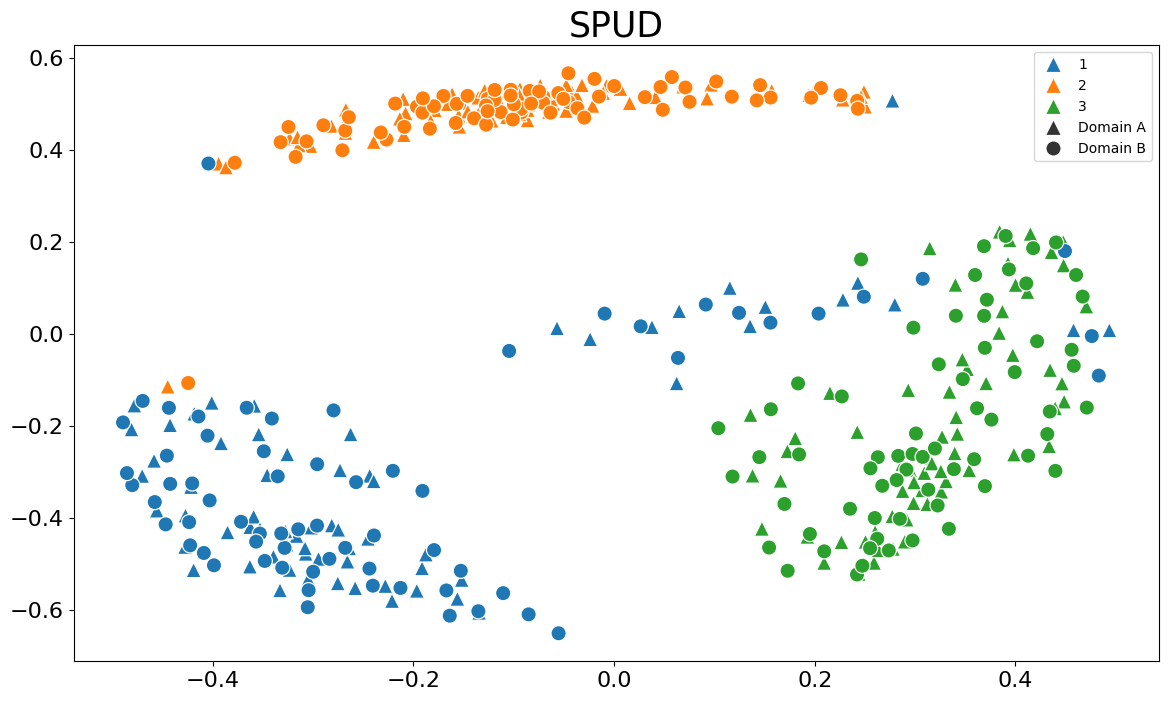

Time it took complete the plots: 0.24


In [95]:
spud_class.plot_emb(labels = dc.labels_doubled, show_anchors = False, show_lines = False)

# Applying RF GAP for MASH

In [76]:
#Create an RF Proximities function
def use_rf_proximities_MASH(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True) #Change Classification to regression

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 1

    return 1 - dataA

In [97]:
#Initialize SPUD Class
mash_class = MASH(distance_measure_A = use_rf_proximities_MASH, distance_measure_B= use_rf_proximities_MASH, knn = 4, verbose = 0, DTM = "hellinger")

#Fit SPUD
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[12:15])

Cross Embedding score: 0.8944723618090453
Fraction of Samples Closest to thier Match: 0.15646069543698393
RF score trained on full Embedding: 0.9296482412060302


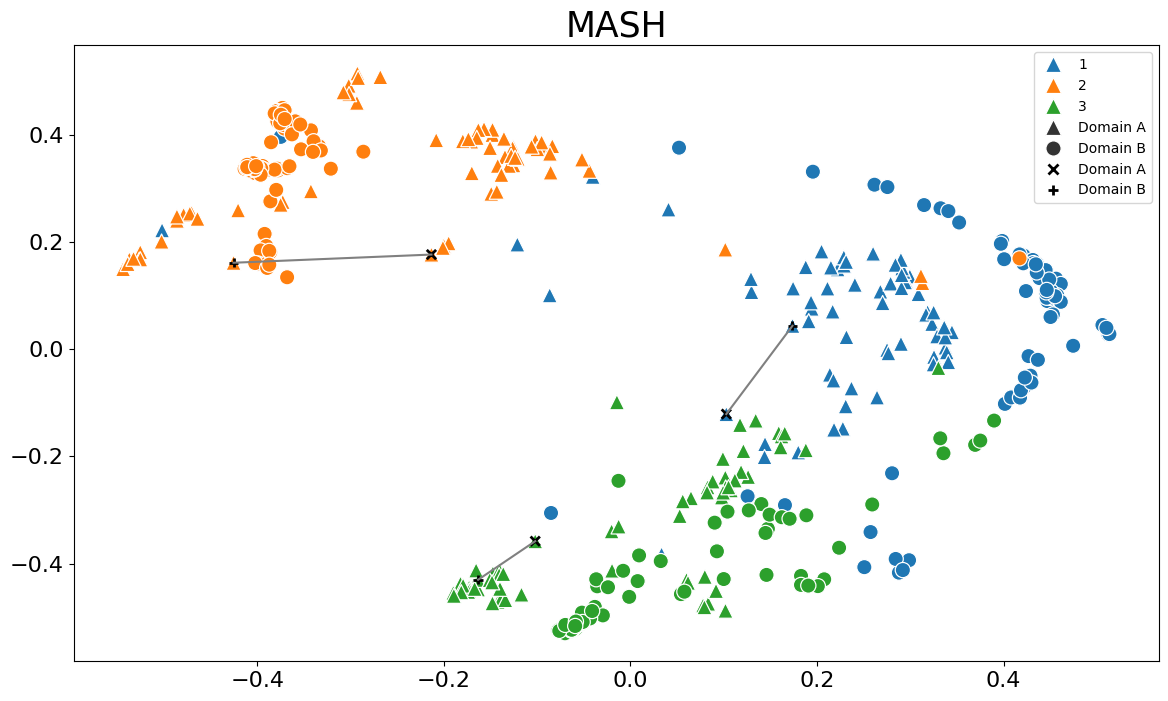

In [98]:
mash_class.plot_emb(labels = dc.labels_doubled, show_anchors = True, show_lines = False)

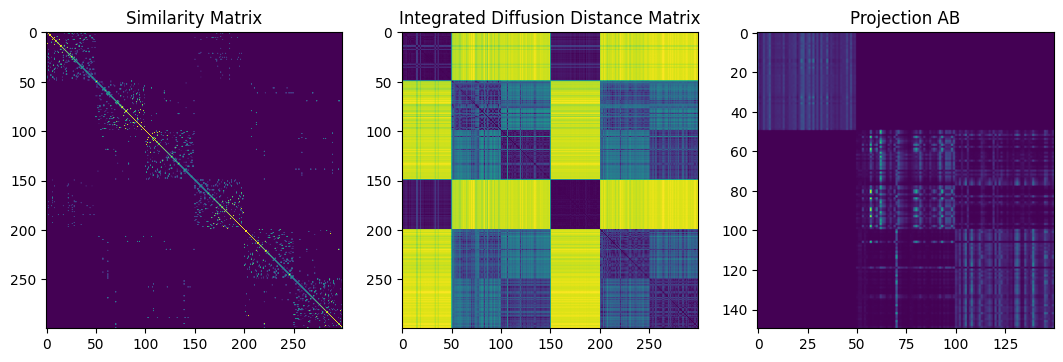

In [11]:
mash_class.plot_heat_maps()

Time Data Below
 Time it took to execute the graph for domain A:  0.07412
 Time it took to compute kernal A:  0.00011
 Time it took to execute the graph for domain B:  0.07246
 Time it took to compute kernal B:  0.00033
 Time it took to compute merge_graphs function:  0.03452
 Time it took to compute similarity_matrix function:  0.00045
Using optimal t value of 21
 Time it took to compute diffusion process:  0.08118
Fit process finished. We recommend calling optimize_by_creating_connections.


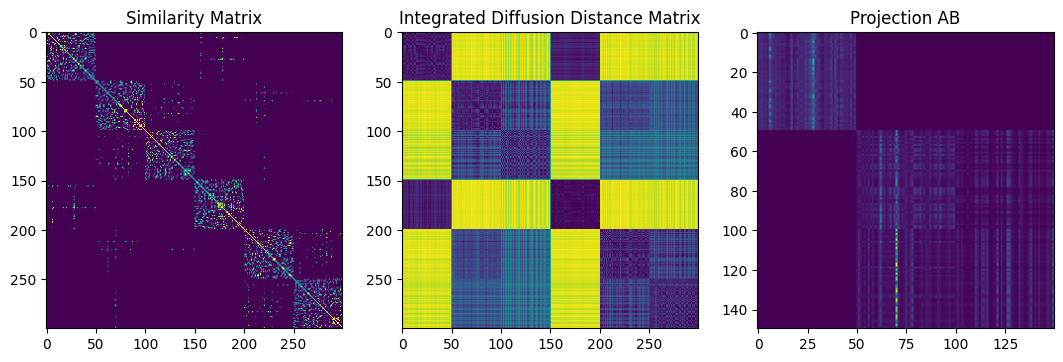

In [12]:
#Initialize SPUD Class
mash_class2 = MASH(knn = 8, verbose = 3, DTM = "log")
mash_class2.fit(dataA = dc.split_A, dataB = dc.split_B, known_anchors = dc.anchors[:4])
mash_class2.plot_heat_maps()

Time it took to calculate the embedding: 0.27999
Calculating the classification Score.
RF-GAP score is accuracy
Cross Embedding score: 0.6666666666666666
Fraction of Samples Closest to thier Match: 0.2477333333333333
RF score trained on full Embedding: 0.9233333333333333


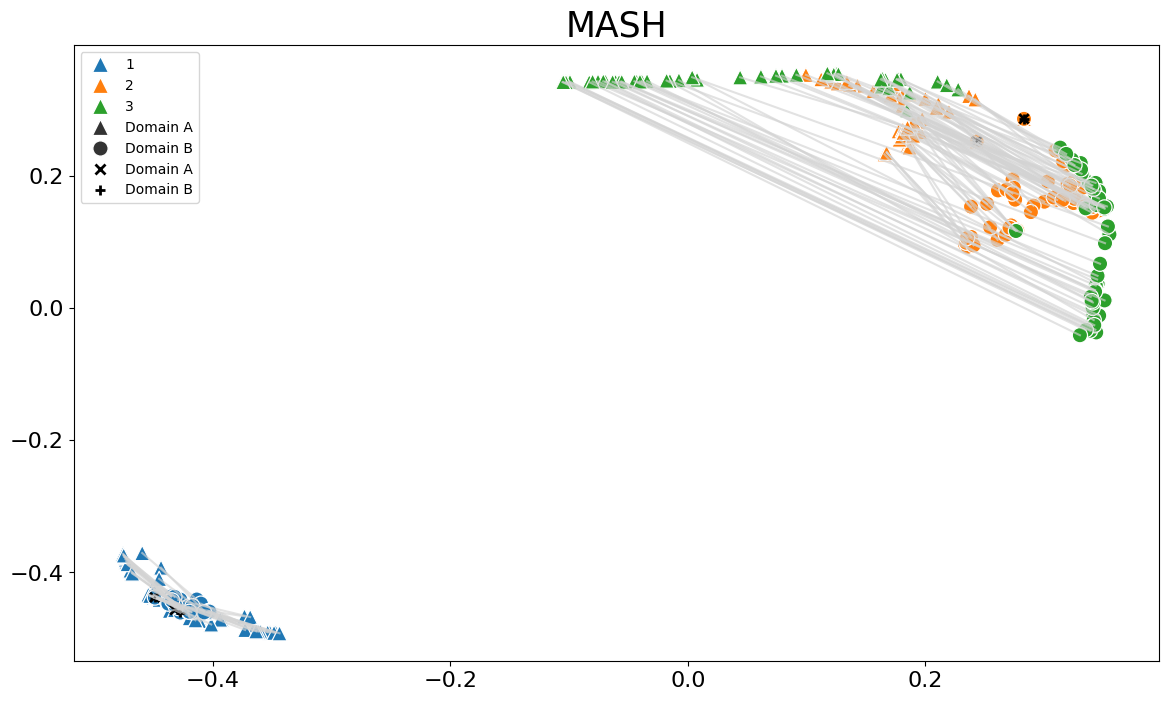

In [13]:
mash_class2.plot_emb(labels = dc.labels_doubled)

<><><><><> Beggining Tests. Original Connections show below <><><><><>


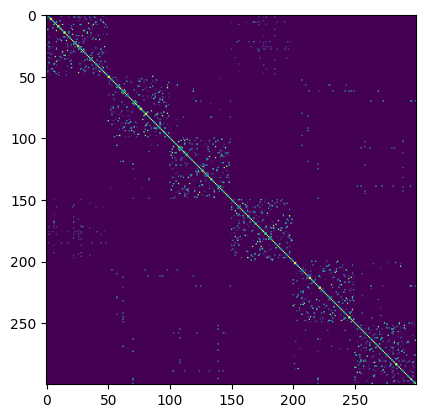

Edges wont be set with similarity measure above: 0.91
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 2372
New connections found: 30


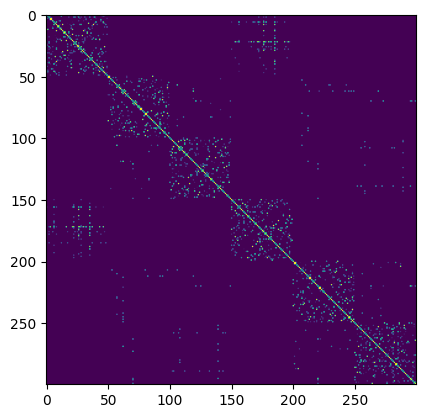

Using optimal t value of 11
The new connections worsened the alignment by 0.004166666666666667
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 2372
New connections found: 30


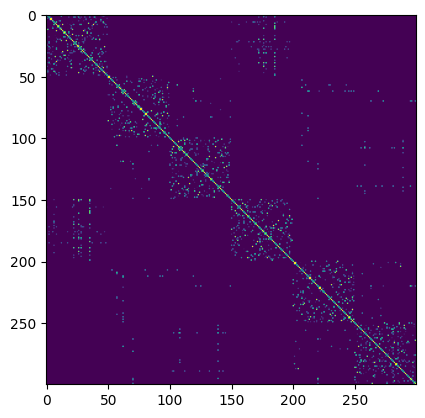

Using optimal t value of 15
The new connections worsened the alignment by 0.0008333333333333326
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 2    <><><><><><><><><><><><><>
Total number of Known_connections: 2372
New connections found: 30


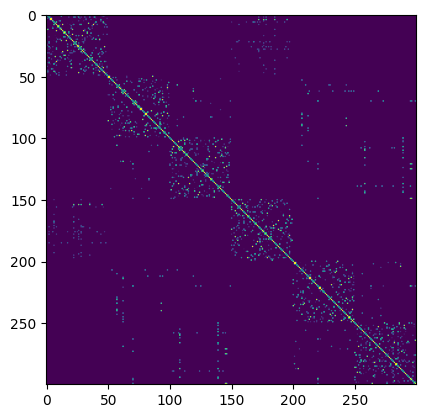

Using optimal t value of 23
The new connections worsened the alignment by 0.01666666666666667
-----------     Pruning the new connections. Continuing...    -----------

Using optimal t value of 18
Added Hold Out Anchor Conections


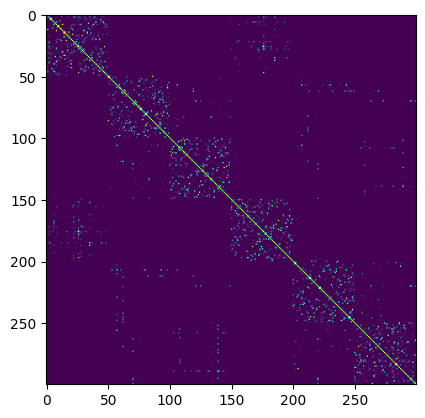

<><><><><><><><><><<><><><><<> Epochs Finished <><><><><><><><><><><><><><><><><>


False

In [14]:
mash_class.optimize_by_creating_connections(epochs=3, connection_limit= 30, threshold = 0.9, hold_out_anchors=dc.anchors[4:8])

Calculating the classification Score.
RF-GAP score is accuracy
Cross Embedding score: 0.9333333333333333
Fraction of Samples Closest to thier Match: 0.16622222222222222
RF score trained on full Embedding: 0.95


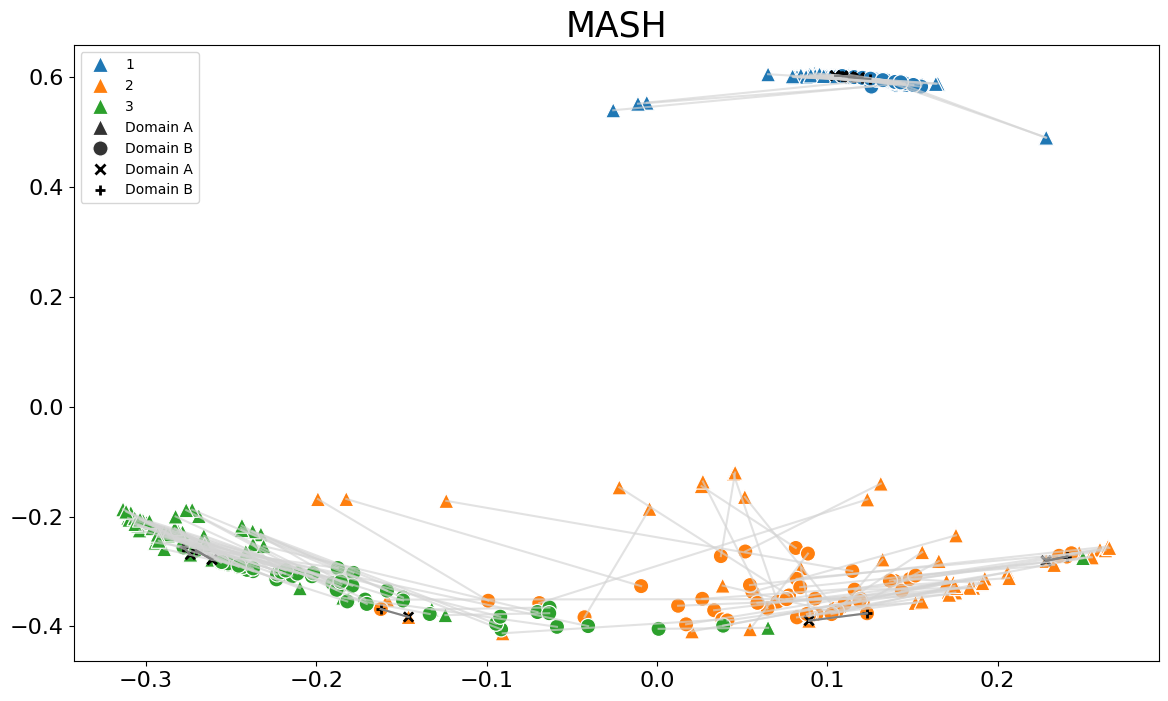

In [15]:
mash_class.plot_emb(labels = dc.labels_doubled)

# Using RF-Extend

### MASH

In [16]:
from Helpers.Pipeline_Helpers import *
from mashspud import MASH
import numpy as np
import pandas as pd
import Main.test_manifold_algorithms as tma
from mashspud import SPUD
from Helpers.rfgap import RFGAP
import matplotlib.pyplot as plt

In [17]:
dc = tma.test_manifold_algorithms(csv_file="Hydrodynamics.csv", split = "random", percent_of_anchors= [0.2], verbose = 4, random_state= 42)

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with Hydrodynamics.csv data       ---------------------------

The knn values are: (2, 9, 16, 23, 30, 37, 44, 51, 58, 65)


In [18]:
mash_class = MASH(distance_measure_A = get_rf_proximites, distance_measure_B= get_rf_proximites, knn = 6, t = -1, verbose = 3, DTM = "log")
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:10])

Time Data Below
 Time it took to execute SGDM for domain A:  0.24077
 Time it took to execute the graph for domain A:  0.00612
 Time it took to execute SGDM for domain B:  0.27921
 Time it took to execute the graph for domain B:  0.00547
 Time it took to compute merge_graphs function:  0.22998
 Time it took to compute similarity_matrix function:  0.0014
Using optimal t value of 5
 Time it took to compute diffusion process:  0.36872
Fit process finished. We recommend calling optimize_by_creating_connections.


In [19]:
mash_class.get_scores(labels = dc.labels_doubled)

Time it took to calculate the embedding: 6.15101
Calculating the R squared score.
RF-GAP score is R^2


(0.5056923595884635, -0.587087662888547, 0.003123873206151928)

In [20]:
from sklearn.model_selection import train_test_split

#Initialize SPUD Class
mash_class = MASH(distance_measure_A = get_rf_proximites, distance_measure_B= get_rf_proximites, knn = 6, t = -1, verbose = 3, DTM = "log")

X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)
labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))

#Fit SPUD
mash_class.fit(dataA = (X_A_train, X_A_test, y_A_train), dataB = (X_B_train, X_B_test, y_B_train), known_anchors = dc.anchors[:10])

Time Data Below


ValueError: Found input variables with inconsistent numbers of samples: [246, 62]

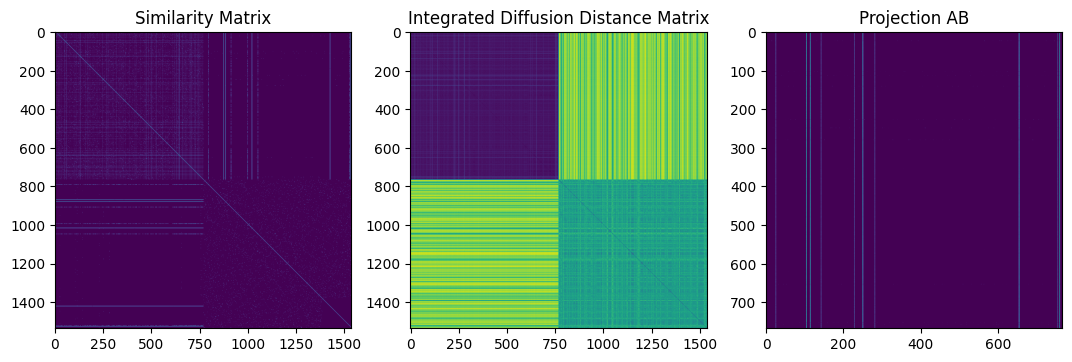

In [ ]:
mash_class.plot_heat_maps()

Calculating the R squared score.
RF-GAP score is R^2
Cross Embedding score: 1.0
Fraction of Samples Closest to thier Match: 0.4065229627821181
RF score trained on full Embedding: 1.0


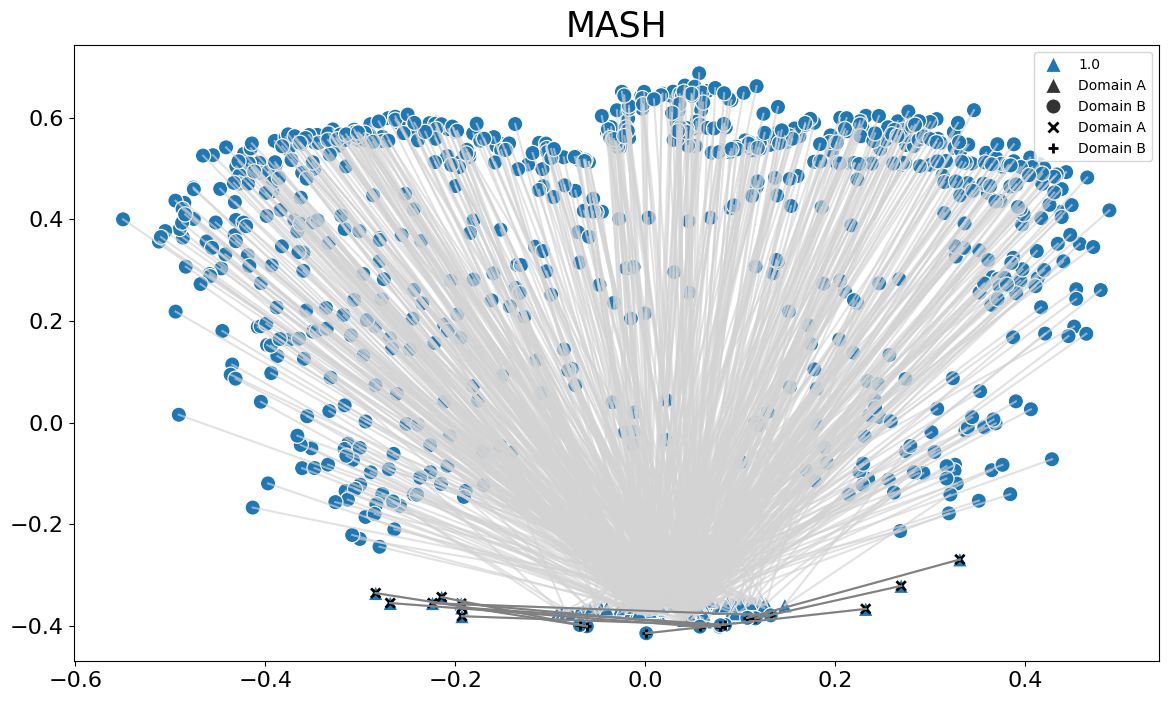

In [ ]:
mash_class.plot_emb(labels=np.ones_like(dc.labels_doubled))

Calculating the classification Score.
RF-GAP score is accuracy
Cross Embedding score: 0.7433333333333334
Fraction of Samples Closest to thier Match: 0.15951111111111113
RF score trained on full Embedding: 0.7733333333333333


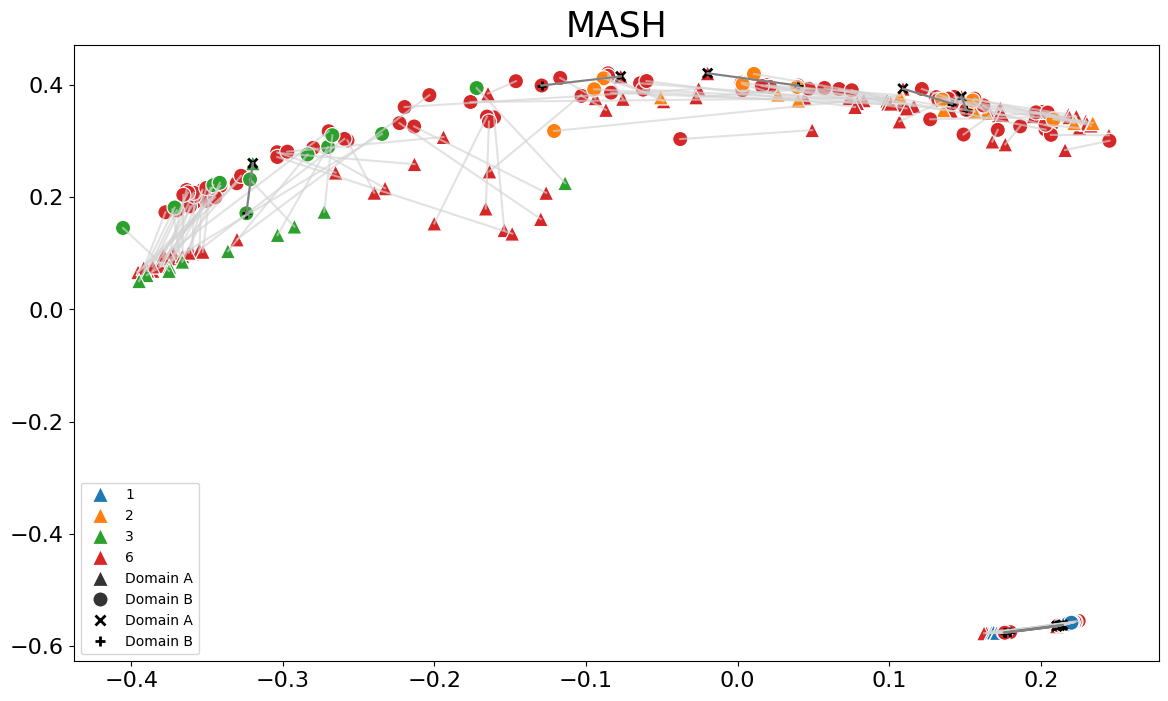

In [ ]:
labels_greyed = np.hstack((np.ones_like(y_A_train)+5, y_A_test, np.ones_like(y_B_train)+5, y_B_test))
mash_class.plot_emb(labels = labels_greyed)

### Spud

In [ ]:
from sklearn.model_selection import train_test_split

#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = rf_test_proximities, distance_measure_B= rf_test_proximities, knn = 3, verbose = 4)

X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)
labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))

#Fit SPUD
spud_class.fit(dataA = (X_A_train, X_A_test, y_A_train), dataB = (X_B_train, X_B_test, y_B_train), known_anchors = dc.anchors[:10])

Time it took to compute SGDM:  0.42
Time it took to execute graphtools.Graph functions:  0.14
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.01
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


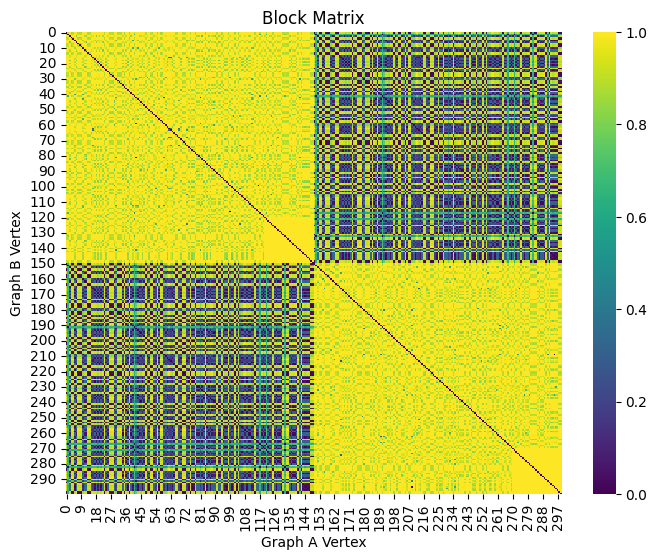

In [ ]:
spud_class.plot_heat_map()

Time it took to calculate the embedding: 0.77
Calculating the classification Score.
RF-GAP score is accuracy
RF score on full embedding: 0.9733333333333334
Cross Embedding score: 0.9833333333333334
Fraction of Samples Closest to thier Match: 0.0010222222222222223


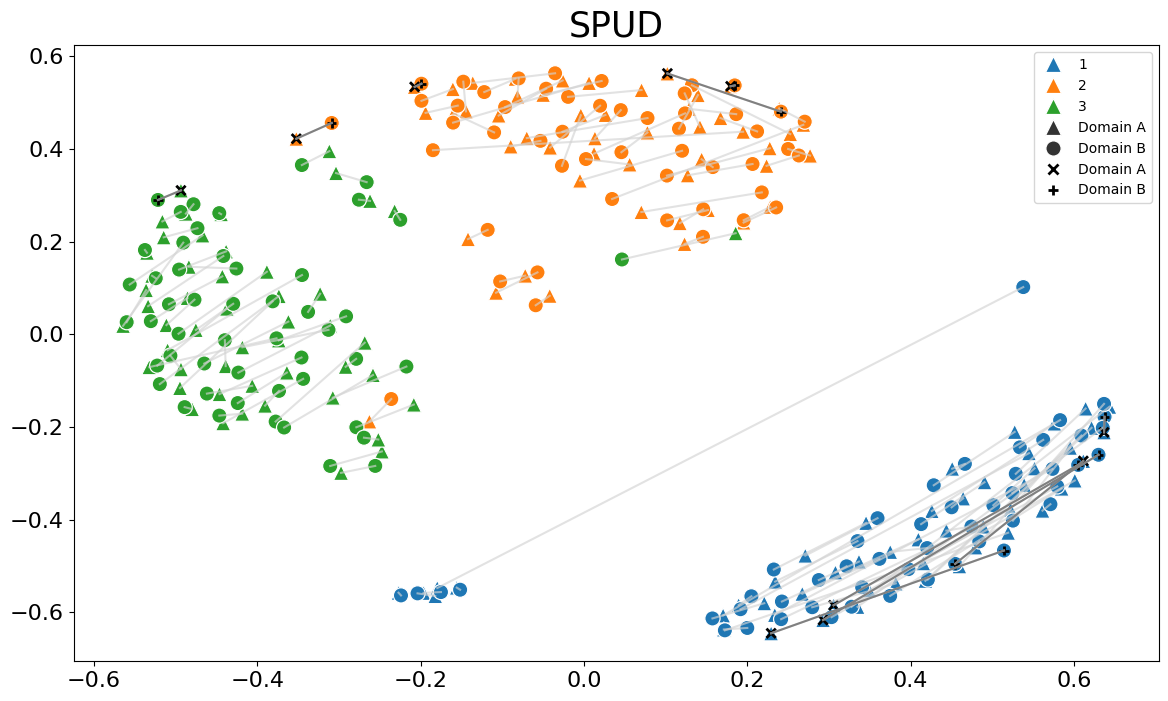

Time it took complete the plots: 0.44


In [ ]:
spud_class.plot_emb(labels = labels_doubled)

Calculating the classification Score.
RF-GAP score is accuracy
RF score on full embedding: 0.77
Cross Embedding score: 0.7833333333333333
Fraction of Samples Closest to thier Match: 0.0010222222222222223


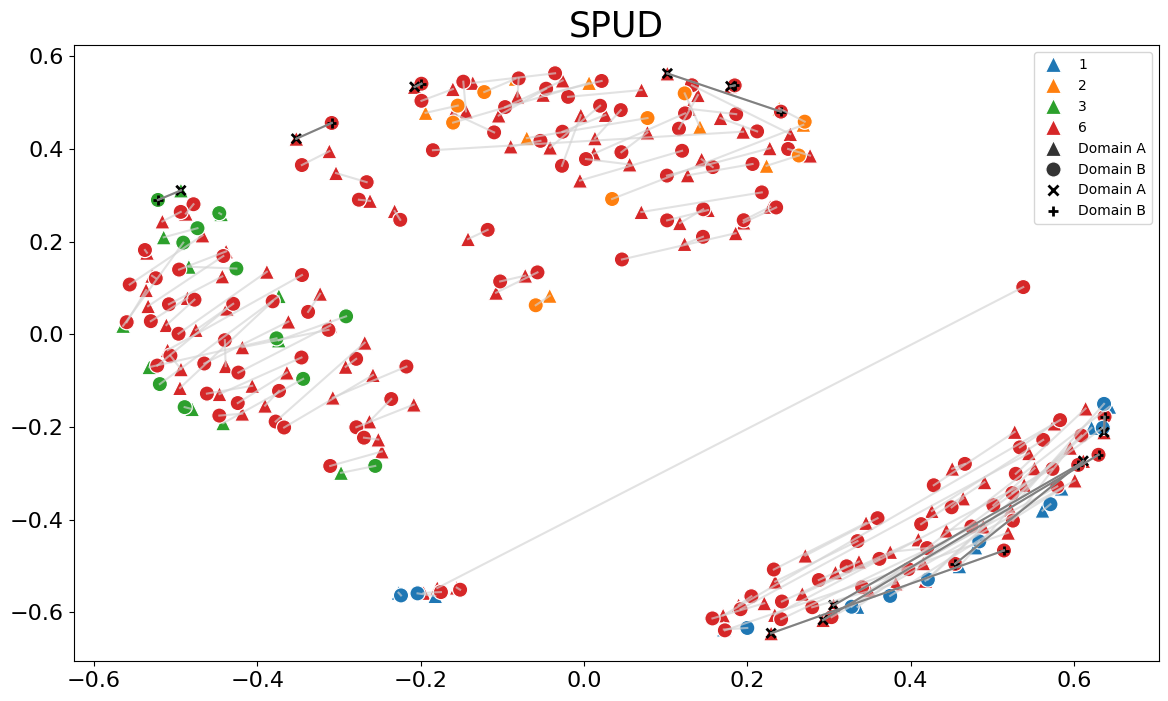

Time it took complete the plots: 0.45


In [ ]:
labels_greyed = np.hstack((np.ones_like(y_A_train)+5, y_A_test, np.ones_like(y_B_train)+5, y_B_test))
spud_class.plot_emb(labels = labels_greyed)